1. ISI
2. Templates overtime 
3. All templates
4. UMAP overtime
5. Features overtime (Pointplots)

In [12]:
BLUE = '#2B4560'

import datetime
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import spikeinterface.core as sc
import spikeinterface.curation as scu
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import sys 

from tqdm.auto import tqdm

# plt.style.use('dark_background')

sys.path.append('src')
from brpylib import NsxFile
from utils import *

sorted_date = '20240112_(detect_threshold=4)'
mice = sorted([mouse_path.split(os.sep)[-1] for mouse_path in glob.glob(f'data{os.sep}sorted{os.sep}{sorted_date}{os.sep}**')])
print(f'mice {mice} were sorted on {sorted_date}')

mice ['1_5', '5_7', '6_2', '6_3', '6_7', '7_2'] were sorted on 20240112_(detect_threshold=4)


# Traces 


063027sebs15001.ns4 opened

063027sebs15001.ns4 closed


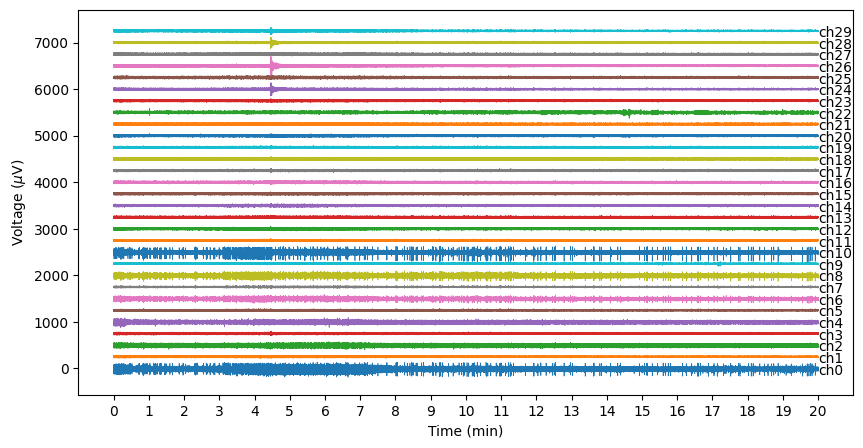

In [2]:
def plot_example_traces(traces, sampling_frequency, trace_gap, figsize=(10, 5), savepath=None):
    plt.figure(figsize=figsize)
    for trace_index, trace in enumerate(traces):
        plt.plot(trace + trace_gap * trace_index, linewidth=0.5)
        plt.text(len(trace), trace_gap * (trace_index - 0.5), f'ch{trace_index}')
    xticks = np.arange(0, traces.shape[1]+1, sampling_frequency * n_s_per_min)
    xtick_labels = [label for label, _ in enumerate(xticks)]
    plt.xticks(xticks, xtick_labels)
    plt.xlabel('Time (min)')
    plt.ylabel(r'Voltage ($\mu$V)')
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    plt.close()

recording_file = 'data/raw/LongTerm/20230707/1_5/063027sebs15001.ns4'
raw_traces, sampling_frequency = read_nsx(recording_file)
recording = se.NumpyRecording(traces_list=raw_traces.T, sampling_frequency=sampling_frequency)
recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
recording_cmr = spre.common_reference(recording_f, reference='global', operator='average')
processed_traces = recording_cmr.get_traces().T

plot_example_traces(processed_traces, sampling_frequency, trace_gap=250)

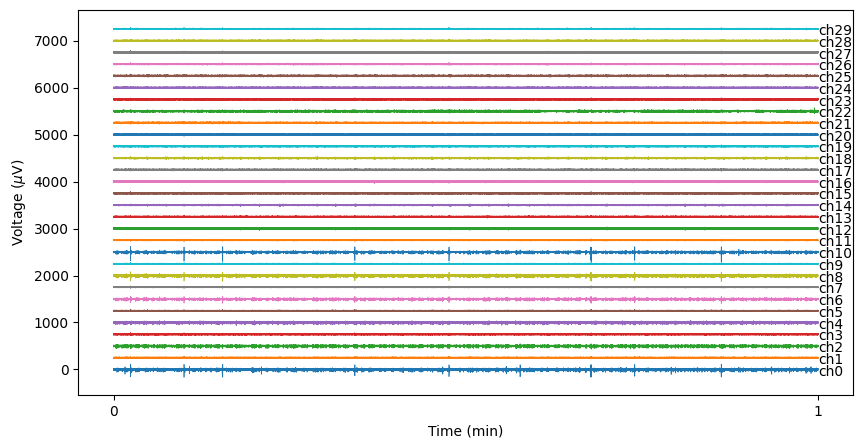

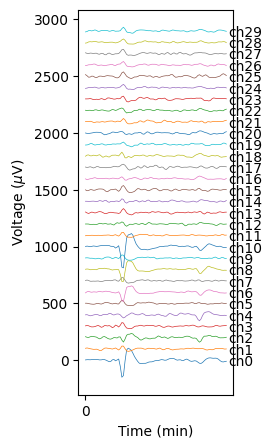

In [3]:
plot_start = 18
plot_end = 19
plot_example_traces(processed_traces[:, int(plot_start*n_s_per_min*sampling_frequency):int(plot_end*n_s_per_min*sampling_frequency)], sampling_frequency, trace_gap=250)

plot_start = 18.02375
plot_end = 18.0239
plot_example_traces(processed_traces[:, int(plot_start*n_s_per_min*sampling_frequency):int(plot_end*n_s_per_min*sampling_frequency)], sampling_frequency, trace_gap=100, figsize=(2, 5))

# Templates

In [13]:
def plot_example_templates(all_templates, extremum_channels, plotted_units, n_col, show_unit_id, color=BLUE, savepath=None):
    n_row = np.ceil(len(plotted_units) / n_col).astype(int)
    plt.figure(figsize=(n_col, n_row))

    plotted_templates = all_templates[plotted_units-1]
    ylims = (plotted_templates.min(), plotted_templates.max())
    for plot_index, unit_id in enumerate(plotted_units):
        ax = plt.subplot(n_row, n_col, plot_index+1)
        
        unit_template = plotted_templates[plot_index, :, extremum_channels[unit_id]]
        ax.plot(unit_template, color=color)
        ax.set_ylim(ylims[0], ylims[1])
        if show_unit_id:
            ax.set_title(unit_id)
        ax.set_xticks([])
        if plot_index != 0:
            ax.set_axis_off()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()
    
mouse = '1_5'
mouse_sorted_folder = f'data{os.sep}sorted{os.sep}{sorted_date}{os.sep}{mouse}'
recording_processed, sorting, waveform_extractor, extremum_channels, mouse_sessions = read_sorted_results(mouse_sorted_folder, read_sessions=True)
all_templates = waveform_extractor.get_all_templates()

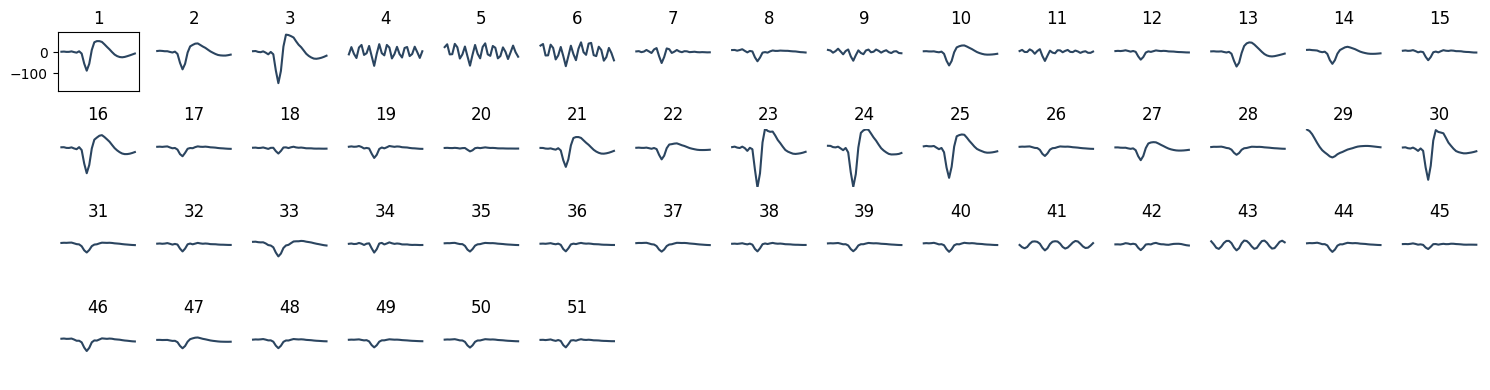

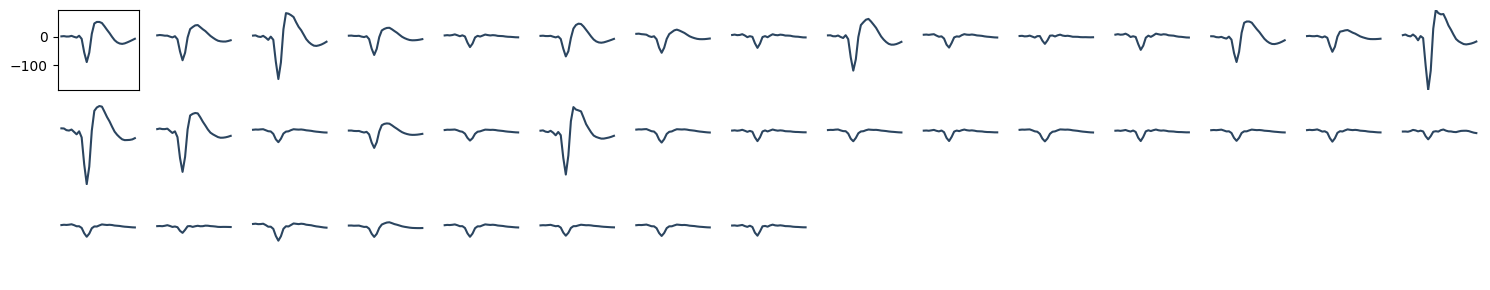

In [15]:
plot_example_templates(all_templates, extremum_channels, plotted_units=sorting.unit_ids, n_col=15, show_unit_id=True)

plot_example_templates(
    all_templates, extremum_channels, 
    plotted_units=np.array(
        [1, 2, 3, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51]
    ), 
    n_col=15, show_unit_id=False,
)

In [16]:
def plot_example_template_by_session(sessions, unit_extremum_waveform_adata, plotted_session_indices, initdate, colormap=plt.cm.turbo, savepath=None):
    plt.figure(figsize=(len(plotted_session_indices)*2, 2.5))
    ylims = (unit_extremum_waveform_adata.X.min(), unit_extremum_waveform_adata.X.max())
    for plot_index, session_i in enumerate(plotted_session_indices):
        ax = plt.subplot(1, len(plotted_session_indices), plot_index+1)
        session_date = sessions.iloc[session_i]['date']
        session_template = unit_extremum_waveform_adata[unit_extremum_waveform_adata.obs['session_i'] == session_i].X.mean(axis=0)
        ax.plot(session_template, color=colormap(session_i / len(sessions)))

        session_lapse = round(((datetime.datetime.strptime(str(session_date), '%Y%m%d') - datetime.datetime.strptime(initdate, '%Y%m%d')).days) / n_day_per_month)
        ax.set_title(f'{session_i}\n{session_date}\n{session_lapse} mo', fontsize=15, color=colormap(session_i / len(sessions)))
        ax.set_ylim(ylims[0], ylims[1])
        if plot_index != 0 :
            ax.set_axis_off()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_unit_longterm_plots(unit_id, sorting, waveform_extractor, extremum_channels, sessions, unit_plotted_session_indices=None, savepath=None):
    unit_extremum_waveform_by_session_adata = get_unit_extremum_waveforms_by_session_adata(unit_id, sorting, waveform_extractor, extremum_channels, sessions, max_count_per_session=None)
    unit_shank_waveform_by_session_adata = get_unit_shank_waveforms_by_session_adata(unit_id, blackrock_channel_indices, sorting, waveform_extractor, extremum_channels, sessions, max_count_per_session=1000)  
    
    def do_plot(plotted_session_indices):
        plot_example_template_by_session(sessions, unit_extremum_waveform_by_session_adata, plotted_session_indices, surgery_dates[mouse])
        plot_isi_by_session(unit_id, sorting, sessions, plotted_session_indices, surgery_dates[mouse], savepath=savepath, colormap=plt.cm.turbo)
        plot_UMAP_by_session(sessions, unit_shank_waveform_by_session_adata, plotted_session_indices, surgery_dates[mouse], savepath=savepath)
        
    do_plot(sessions.index)
    if unit_plotted_session_indices is not None:
        do_plot(unit_plotted_session_indices)

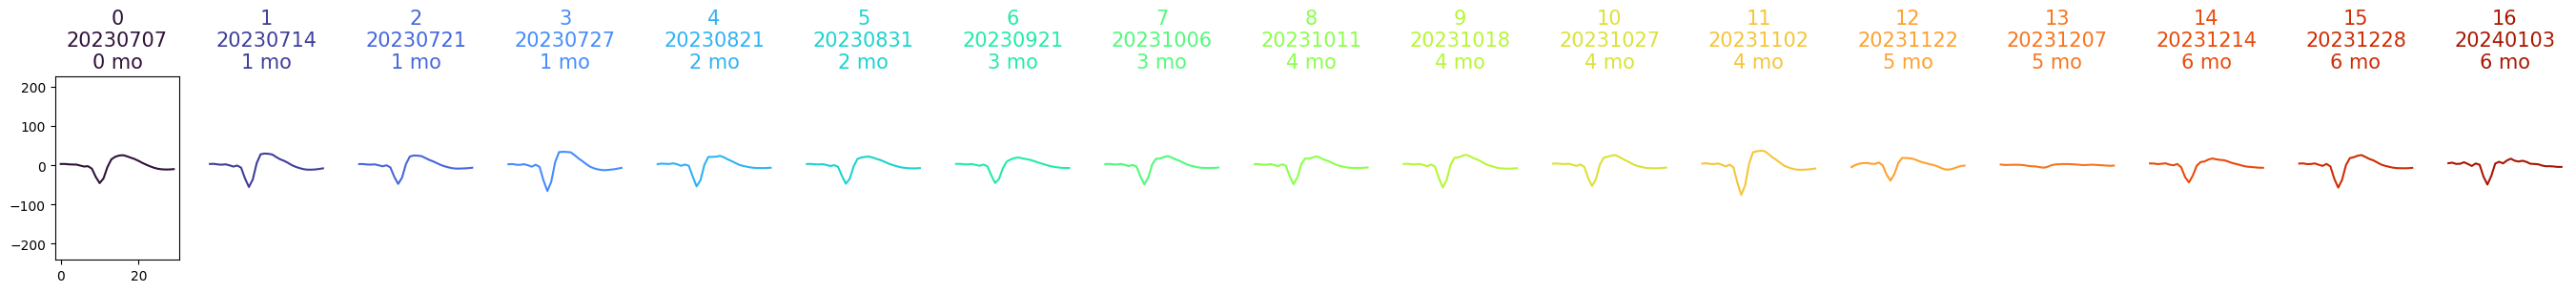

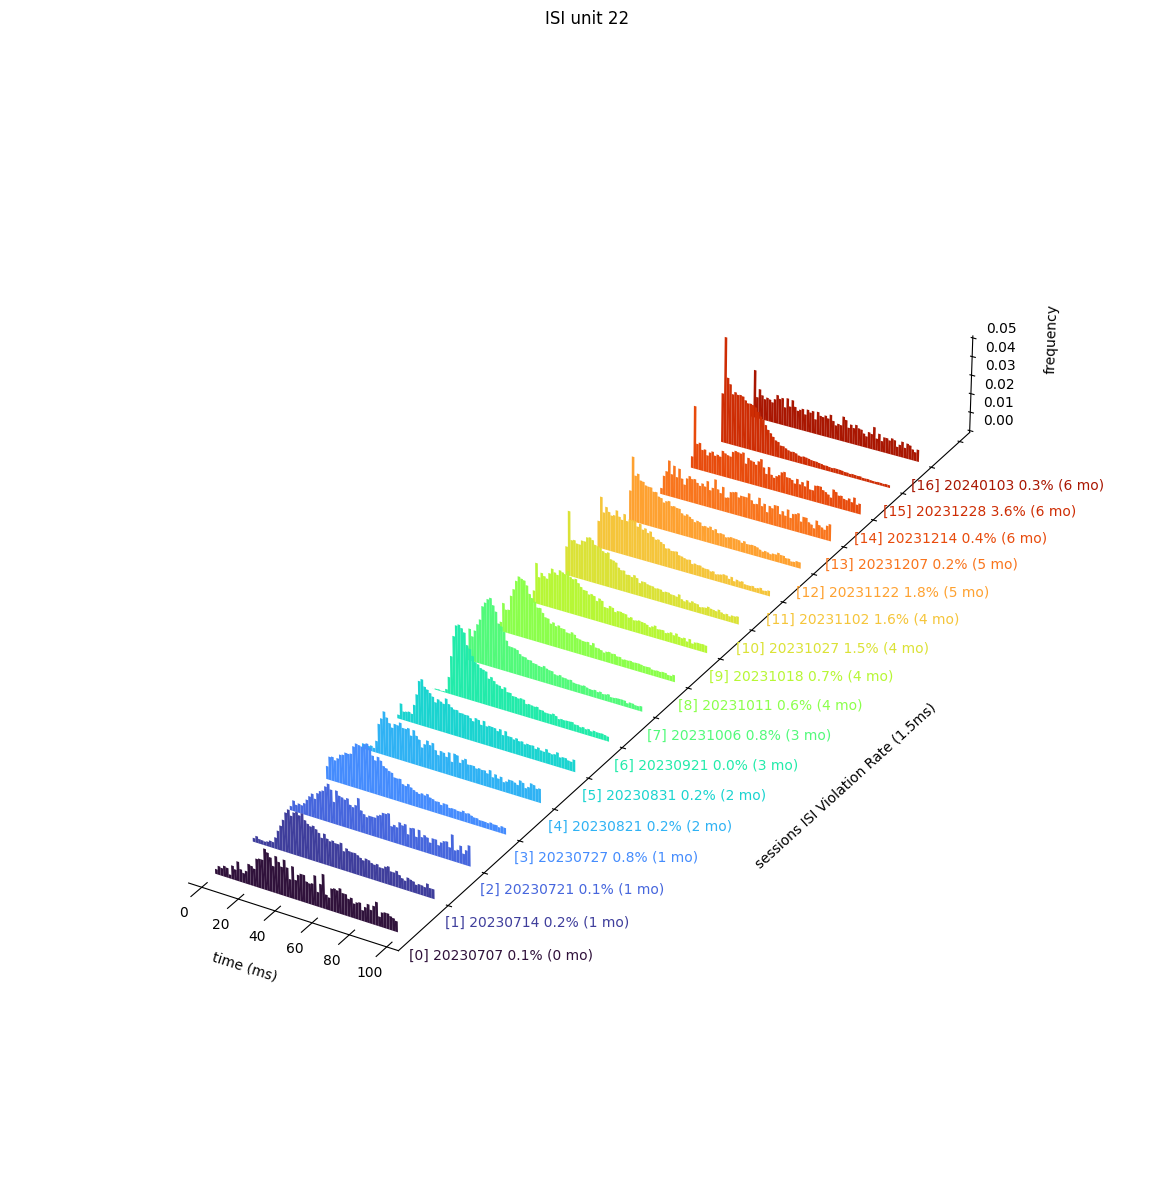

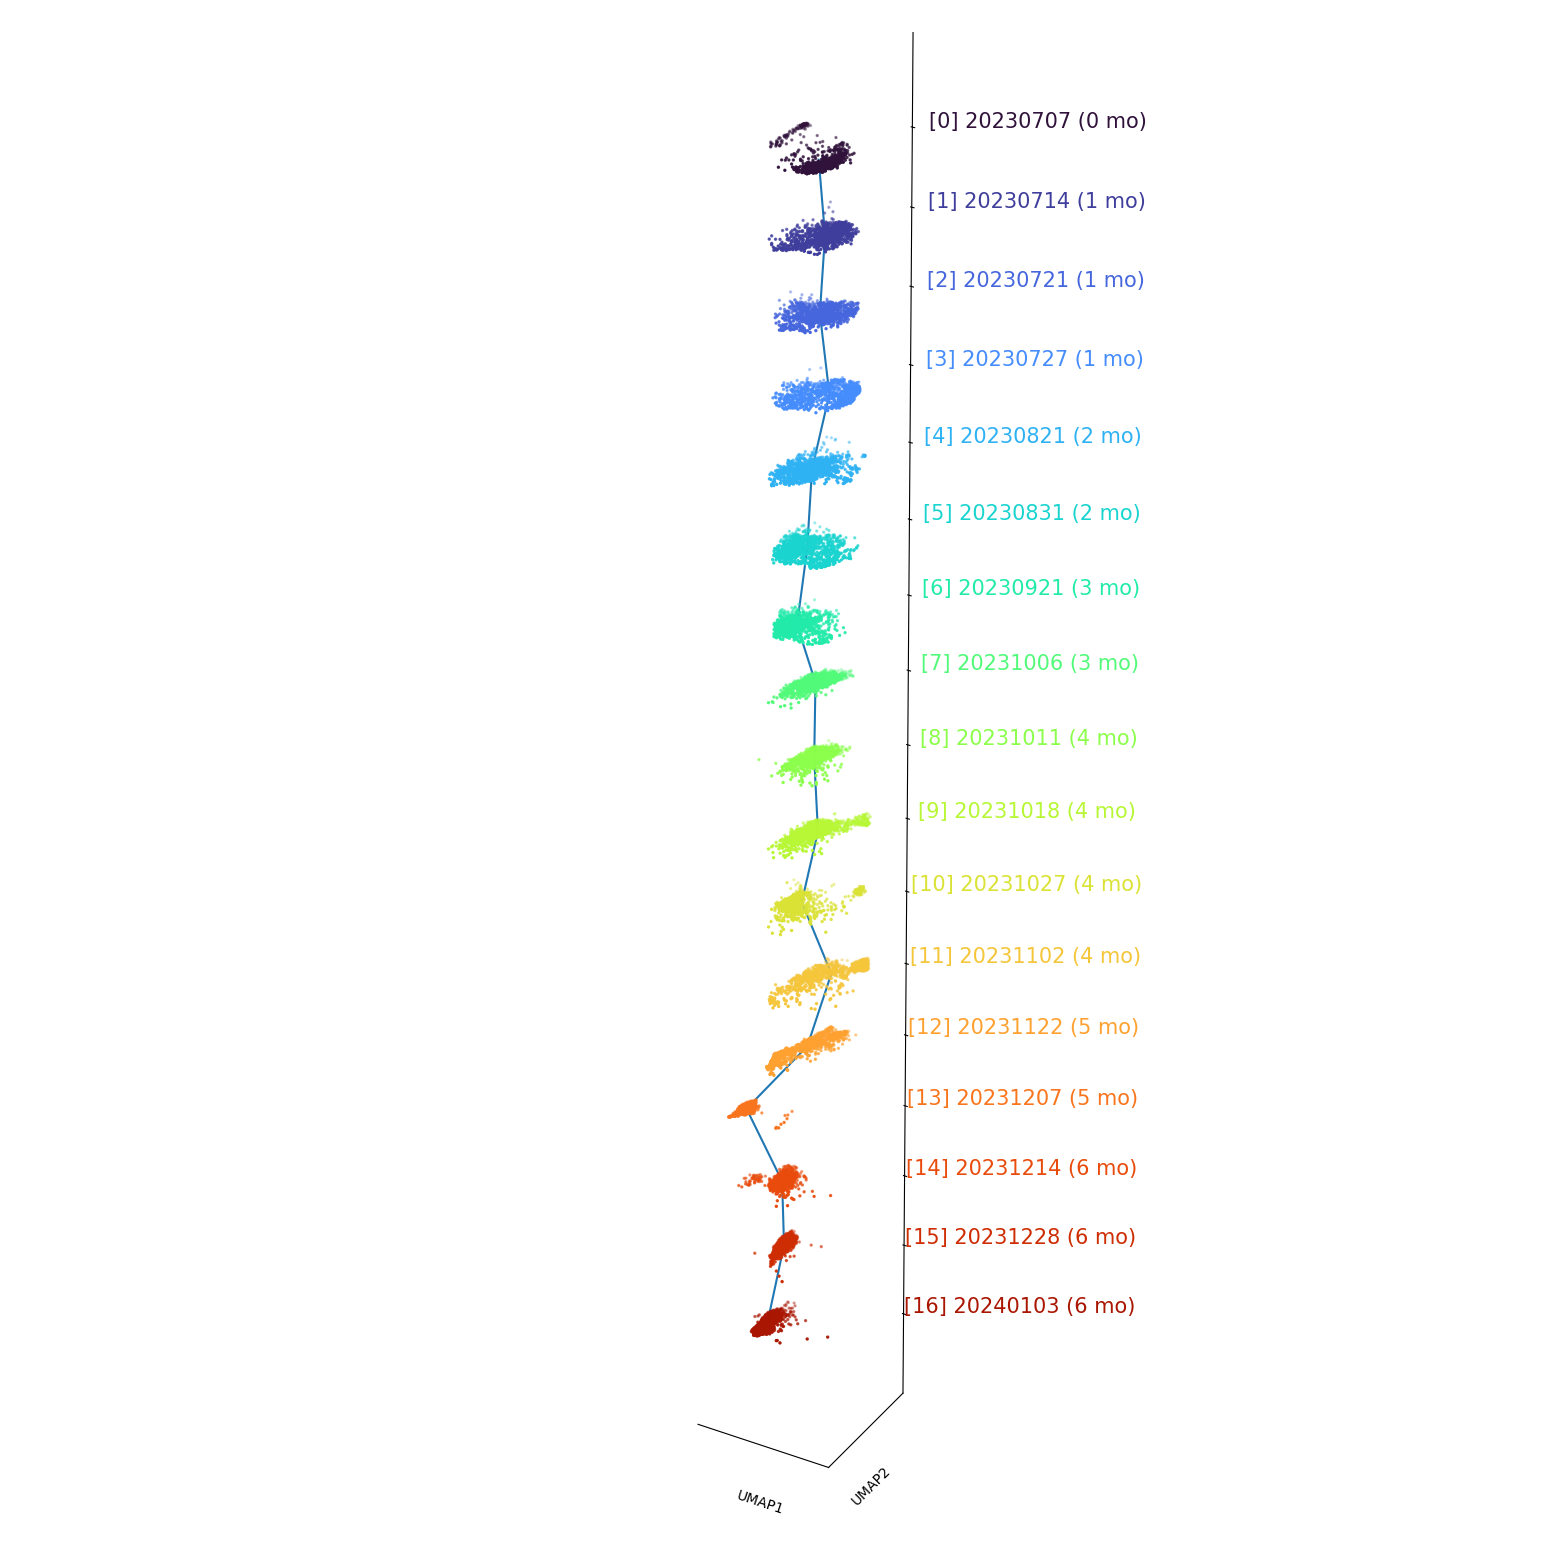

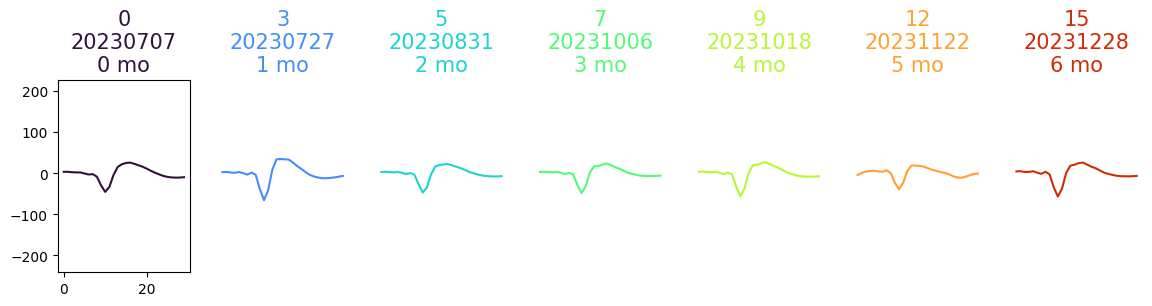

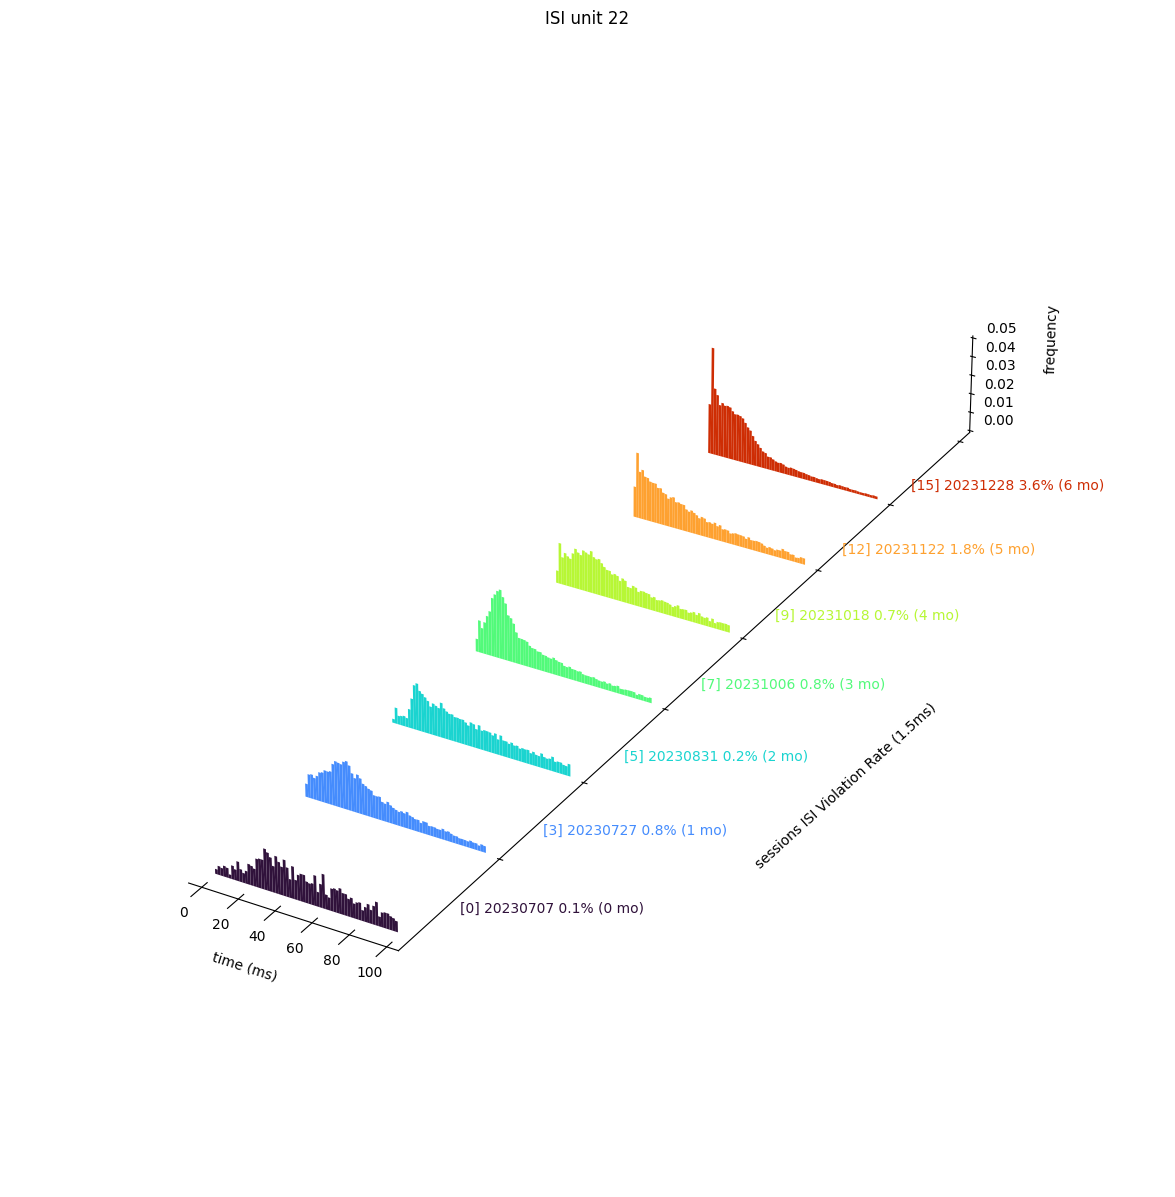

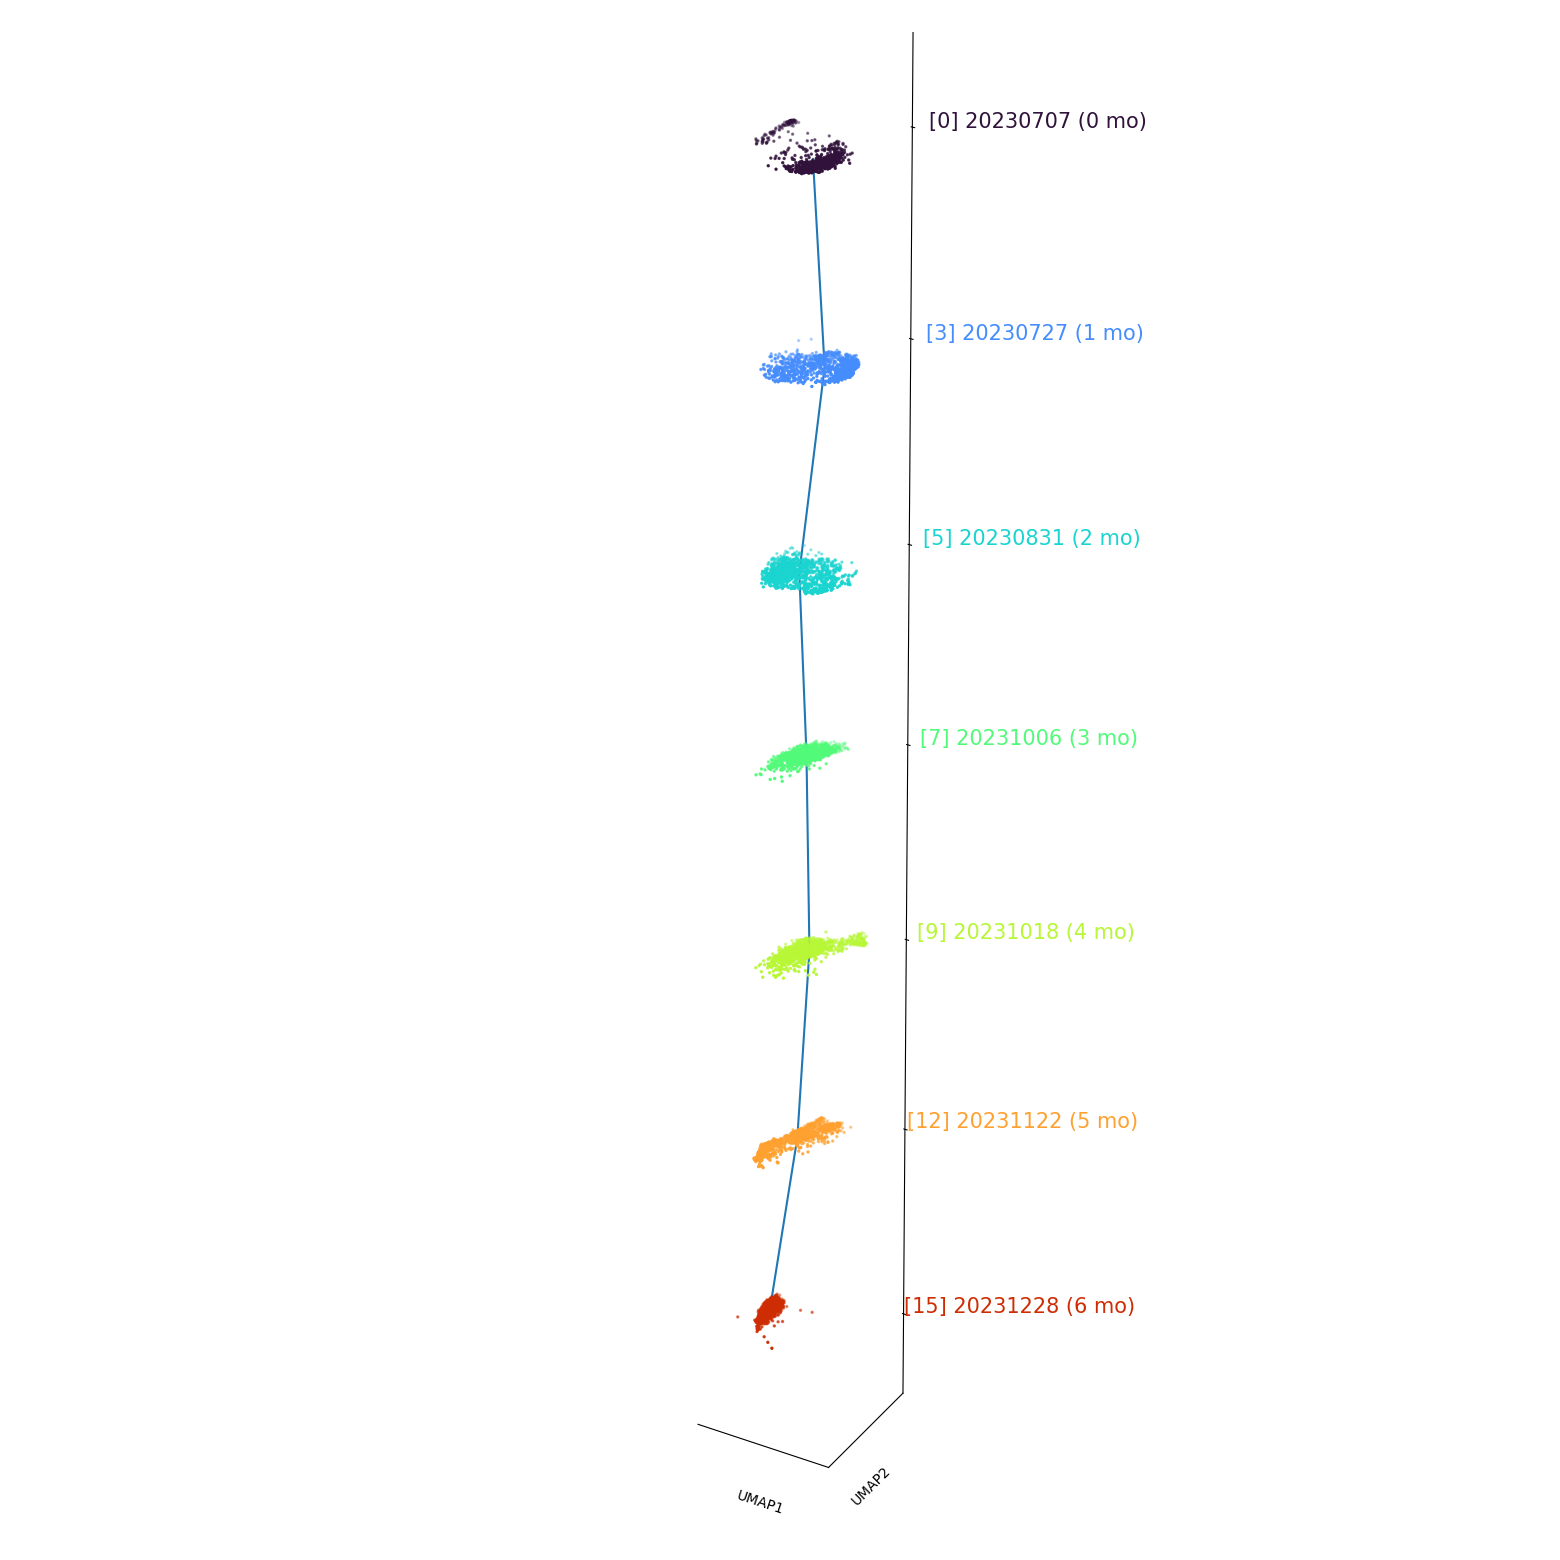

In [18]:
unit_id = 22
unit_plotted_session_indices =[0, 3, 5, 7, 9, 12, 15]
plot_unit_longterm_plots(unit_id, sorting, waveform_extractor, extremum_channels, mouse_sessions, unit_plotted_session_indices=unit_plotted_session_indices)

# Amplitudes

# Firing Rates

# Waveform Similarity